In [136]:
from config import Config
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas
import os
import m3u8
from datetime import datetime
from datetime import timedelta
import re
import copy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

channel="nickjr_rom"
txdate="2019-11-10"


In [137]:
def get_commercial_log(channel,txdate):
    breaks=[]
    local_feed=[lf for lf in Config.LOCALIZED_FEEDS if lf["dir"]==channel][0]
    xls_filename=os.path.join(Config.STREAMS_ROOT,local_feed["dir"],"commercials","playlists",
                          txdate,txdate+"_"+local_feed["log"]+".xls")
    df=pandas.read_excel(xls_filename)
    for b in df["Break Number"].unique():
        com_break={}
        com_break["id"]=b
        com_break["starttime"]=df[df["Break Number"] == b].iloc[0]["Start Time"][0:-3]
        com_break["duration"]='{:02d}:{:02d}'.format(int(df[df["Break Number"] == b]["Duartion WORK"].sum()/60),
                                             df[df["Break Number"] == b]["Duartion WORK"].sum()%60)
        if os.path.isfile(os.path.join(Config.STREAMS_ROOT,local_feed["dir"],"commercials","playlists",
                                           txdate,'brk_{:02d}'.format(b),"playlist.m3u8")):
            com_break["manifest"]=os.path.join(Config.BASE_URI,local_feed["dir"],"commercials","playlists",
                                           txdate,'brk_{:02d}'.format(b),"playlist.m3u8")
            com_break["segments"]=[]
            for segment in m3u8.load(com_break["manifest"]).segments:
                com_break["segments"].append(segment.uri)
        breaks.append(com_break)
    return breaks

In [138]:
def ts_to_datetime(ts):
    (hour,min,sec)=ts.split(':')
    return datetime(1900,1,int(int(hour)/24)+1,int(hour)%24,int(min),int(sec.split('.')[0]),int(sec.split('.')[1]))

def ts_to_timedelta(ts):
    (hour,min,sec)=ts.split(':')
    return timedelta(hours=int(hour),minutes=int(min),seconds=int(sec.split('.')[0]),microseconds=int(sec.split('.')[1]))

def get_segments_played(channel,txdate):
    downloads=[]
    parse_packets=[]
    regex_download=r"([^\s]*)(.*)(http:.*)"
    regex_timestamp=r"([^\s]*).*Pushing out pending packets at: ([^\s]*) ([^\s]*).*Timestamp:([^\s]*) DUR:([^\s]*) SIZE:([^\s]*)"
    hls2rtp_logs="/ddrive/ottstreamer/hls2rtp/logs"
    local_feed=[lf for lf in Config.LOCALIZED_FEEDS if lf["dir"]==channel][0]
    txdate_datetime=datetime.strptime(txdate,'%Y-%m-%d')
    if txdate_datetime.date()==datetime.now().date():
        hls2rtp_log=os.path.join(hls2rtp_logs,"hls2rtp_"+local_feed["dir"]+".log")
    else:
        hls2rtp_log=os.path.join(hls2rtp_logs,"hls2rtp_"+local_feed["dir"]+".log-"+txdate_datetime.strftime('%Y%m%d'))

    base_wallclock=datetime(1900, 1, 1, 0, 0)
    base_timestamp=datetime(1900, 1, 1, 0, 0)
    prev_end_timestamp=datetime(1900, 1, 1, 0, 0)
    prev_end_timestamp_tp=datetime(1900,1,1,0,0)
    download={}
    with open(hls2rtp_log) as file:
        for ln,line in enumerate(file):
            if "Pushing out pending packets at:" in line:
                parse_packet={}
                if line.find("percent. ") > 0:
                    line=line[line.find("percent. ")+9:]
                match=re.search(regex_timestamp,line)
                base_timestamp=ts_to_datetime(match.group(1)[0:-3])
                base_wallclock=datetime.strptime(match.group(2) +" " + match.group(3),"%Y-%m-%d %H:%M:%S.%f")
                parse_packet["linenumber"]=ln
                parse_packet["wallclock"]=datetime.strptime(match.group(2) +" " + match.group(3),"%Y-%m-%d %H:%M:%S.%f")
                parse_packet["timestamp"]=ts_to_datetime(match.group(1)[0:-3])
                parse_packet["PCR"]=ts_to_datetime(match.group(4)[0:-3])
                parse_packet["Duration"]=ts_to_timedelta(match.group(5)[0:-3])
                parse_packet["Size"]=int(match.group(6))
                parse_packet["gap"]=parse_packet["timestamp"]-prev_end_timestamp_tp
                prev_end_timestamp_tp=parse_packet["timestamp"]+parse_packet["Duration"]
                parse_packets.append(parse_packet)
                

            elif "Downloading fragment uri" in line:
                match=re.search(regex_download,line)
                download={}
                download["gap"]=ts_to_datetime(match.group(1)[0:-3])-prev_end_timestamp
                download["start_linenumber"]=ln
                download["start_timestamp"]=ts_to_datetime(match.group(1)[0:-3])
                download["start_wallclock"]=base_wallclock+(download["start_timestamp"]-base_timestamp)
                download["url"]=match.group(3).split(' ')[0][0:-1]
            elif "fragment download finished" in line:
                match=re.search(regex_download,line)
                download["end_linenumber"]=ln
                download["end_timestamp"]=ts_to_datetime(match.group(1)[0:-3])
                prev_end_timestamp=download["end_timestamp"]
                download["end_wallclock"]=base_wallclock+(download["end_timestamp"]-base_timestamp)
                download["result"]=match.group(3).split(' ')[1]
                download["result2"]=match.group(3).split(' ')[2]
                if "start_wallclock" in download:
                    downloads.append(download)
    return downloads,parse_packets

In [139]:
#  ar: TS segments downloaded over the day
#  tp: Packets sent by tsparse over the day
cl=get_commercial_log(channel,txdate)
ar,tp=get_segments_played(channel,txdate)

In [140]:
#As-run log of commecial breaks...
for brk in cl:
    try:
        com_fragments=[]
        for segment in brk["segments"]:
            com_fragments.append([a["url"] for a in ar].index(segment))
        print('Break {} scheduled for {} is played at {} with duration:{}.'.
              format(brk["id"],brk["starttime"],ar[com_fragments[0]]["start_wallclock"].strftime('%H:%M:%S'),
                    (ar[com_fragments[-1]]["end_wallclock"]-ar[com_fragments[0]]["start_wallclock"])))
    except:
        print('Break {} scheduled for {} is not played.'.format(brk["id"],brk["starttime"]))

Break 1 scheduled for 06:21:00 is played at 06:23:01 with duration:0:06:19.970806.
Break 2 scheduled for 06:50:00 is played at 06:51:36 with duration:0:05:40.320207.
Break 3 scheduled for 07:17:00 is played at 07:19:44 with duration:0:06:20.234845.
Break 4 scheduled for 07:48:00 is played at 07:49:26 with duration:0:05:40.010071.
Break 5 scheduled for 08:26:00 is played at 08:25:37 with duration:0:05:40.434671.
Break 6 scheduled for 09:22:00 is played at 09:21:32 with duration:0:06:20.017623.
Break 7 scheduled for 09:50:00 is played at 09:49:42 with duration:0:05:40.163585.
Break 8 scheduled for 10:18:00 is played at 10:17:42 with duration:0:06:20.038516.
Break 9 scheduled for 10:52:00 is played at 10:51:15 with duration:0:05:40.399079.
Break 10 scheduled for 11:20:00 is played at 11:19:24 with duration:0:06:19.938752.
Break 11 scheduled for 11:49:00 is played at 11:47:54 with duration:0:05:40.989070.
Break 12 scheduled for 12:16:00 is played at 12:15:39 with duration:0:06:19.995355.
B

Total samples:3800


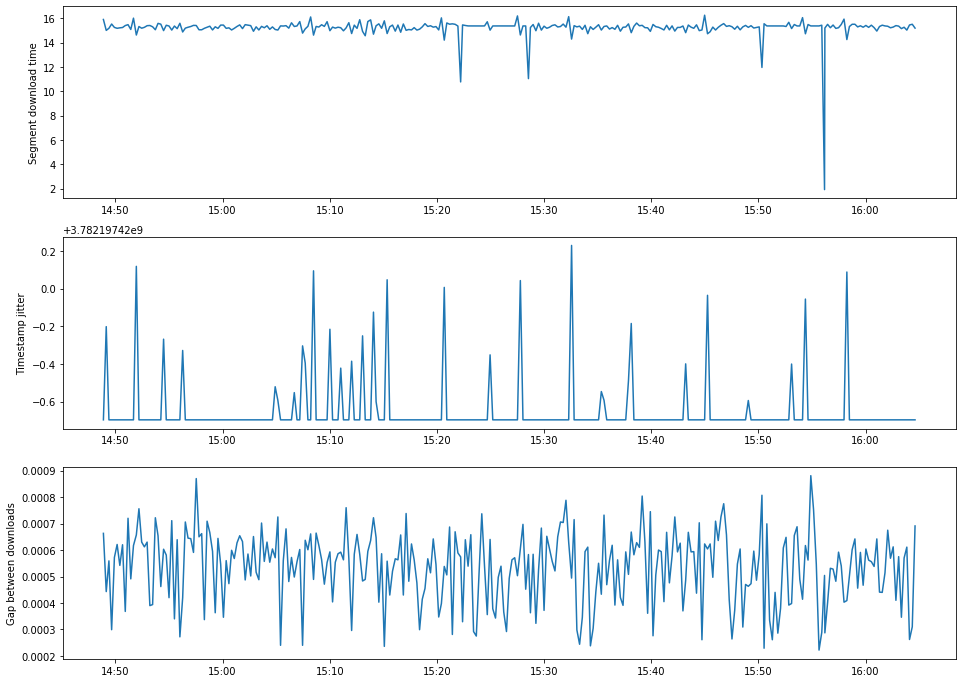

In [141]:
start=3500
stop=3800 #len(ar)
print("Total samples:{}".format(stop))
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(16, 12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.plot([a["start_wallclock"] for a in ar[start:stop]],
            [(a["end_wallclock"]-a["start_wallclock"]).total_seconds() for a in ar[start:stop]]);
ax1.set_ylabel("Segment download time");
#ax2.hist( [(a["end_wallclock"]-a["start_timestamp"]).total_seconds() for a in ar[start:stop]],log=True,bins=100);
ax2.plot( [a["start_wallclock"] for a in ar[start:stop]],
         [(a["start_wallclock"]-a["start_timestamp"]).total_seconds() for a in ar[start:stop]]);
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'));
ax2.set_ylabel("Timestamp jitter");

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.plot([a["start_wallclock"] for a in ar[start:stop]],
            [a["gap"].total_seconds() for a in ar[start:stop]]);
ax3.set_ylabel("Gap between downloads");


In [142]:
# Slow downloads
[a for a in ar if (a["end_wallclock"]-a["start_wallclock"])>timedelta(seconds=25)]

[]

Total number of packets:121000


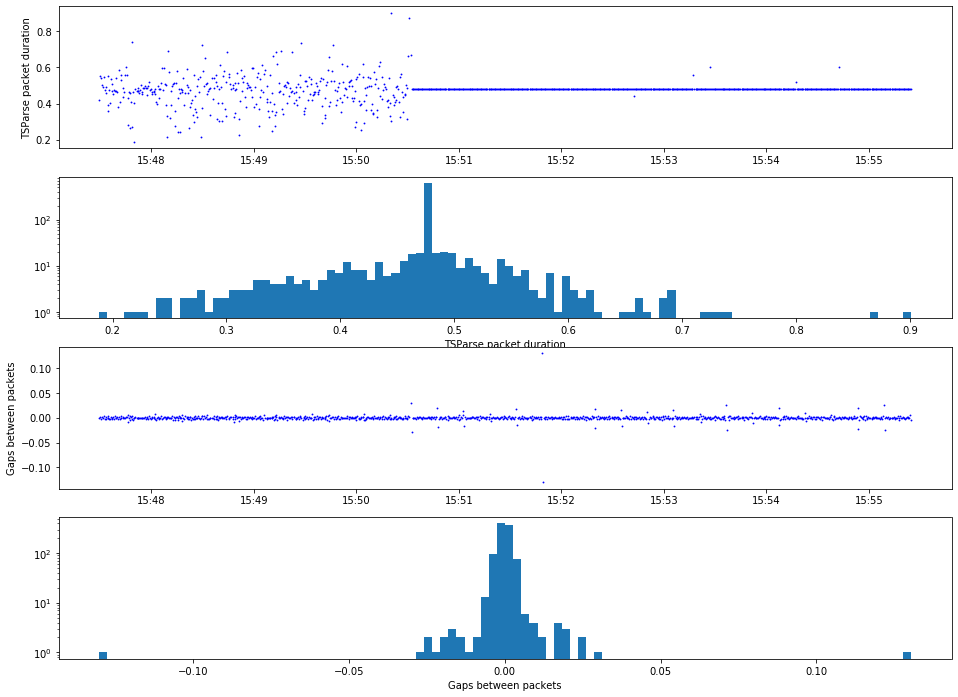

In [143]:
#tsparse packet durations...
tp_start=120000
tp_end=121000 #len(tp)
print("Total number of packets:{}".format(tp_end))
fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(16,12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.plot([t["wallclock"] for t in tp[tp_start:tp_end]],[t["Duration"].total_seconds() for t in tp[tp_start:tp_end]],"bp",markersize=1)
ax1.set_ylabel("TSParse packet duration");
ax2.hist( [t["Duration"].total_seconds() for t in tp[tp_start:tp_end]],log=True,bins=100);
ax2.set_xlabel("TSParse packet duration");
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.plot([t["wallclock"] for t in tp[tp_start:tp_end]],[t["gap"].total_seconds() for t in tp[tp_start:tp_end]],"bp",markersize=1);
ax3.set_ylabel("Gaps between packets");
ax4.hist( [t["gap"].total_seconds() for t in tp[tp_start:tp_end]],log=True,bins=100);
ax4.set_xlabel("Gaps between packets");


In [144]:
#TSParse packets with 0 duration
[t for t in tp if t["Duration"].total_seconds()==0]

[]

In [145]:
[t["gap"].total_seconds() for t in tp ]

[135457.805854,
 0.00327,
 -0.001399,
 -0.003547,
 0.005563,
 -0.0024,
 -0.000389,
 -0.003545,
 4.8e-05,
 0.001586,
 0.004016,
 -0.001586,
 -0.001848,
 0.019436,
 -0.020009,
 0.001421,
 0.000574,
 -0.001147,
 0.000766,
 0.002542,
 -0.004562,
 0.000485,
 0.000665,
 0.007569,
 -0.004742,
 0.000587,
 -0.004741,
 0.003901,
 0.000539,
 -0.000107,
 0.000674,
 0.00077,
 -0.001822,
 -0.001006,
 -0.00086,
 0.000533,
 8.1e-05,
 0.001442,
 -0.001817,
 0.003673,
 -0.000904,
 0.000855,
 -0.004074,
 0.00073,
 0.003161,
 -0.002356,
 0.001248,
 -0.000616,
 -0.001177,
 -0.002348,
 -0.001188,
 0.001494,
 0.000301,
 -0.001261,
 0.004312,
 0.003267,
 -0.005037,
 -0.003512,
 0.003073,
 0.001491,
 0.000667,
 -0.002297,
 0.001012,
 0.002007,
 -0.001644,
 0.000754,
 -0.001213,
 0.001872,
 -0.002404,
 0.000387,
 -0.001718,
 0.002361,
 -0.001723,
 -0.001661,
 0.00088,
 -0.00314,
 0.004703,
 -0.000563,
 -0.001843,
 0.002236,
 0.00029,
 -0.001301,
 0.0025,
 -0.002327,
 -0.000608,
 0.002467,
 0.000872,
 -0.000271,

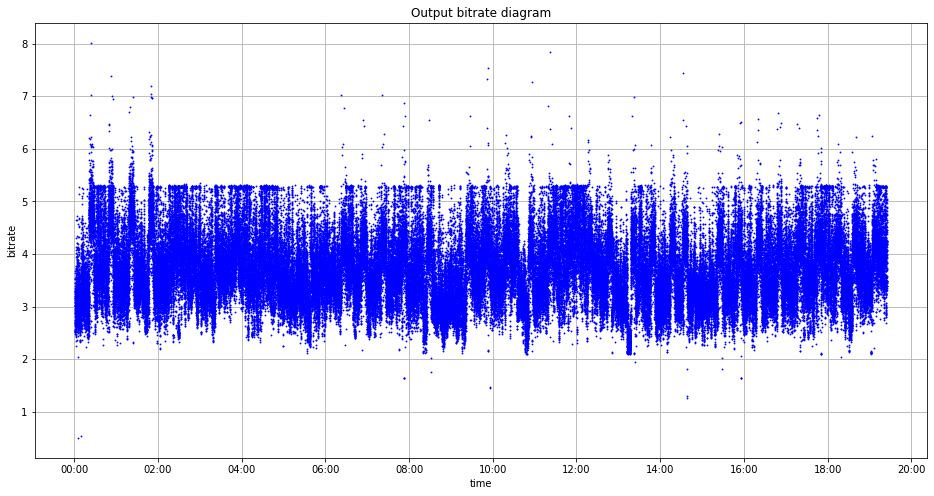

In [146]:
#output bitrate..
fig,ax1=plt.subplots(figsize=(16,8))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.plot([t["wallclock"]for t in tp if t["Duration"].total_seconds()>0],
         [t["Size"]*8/1000000/t["Duration"].total_seconds() for t in tp if t["Duration"].total_seconds()>0],"bp",markersize=1);
plt.xlabel("time");
plt.ylabel("bitrate");
plt.title("Output bitrate diagram");
plt.grid(True);


In [147]:
#Packets with duration > 2sec.  Most likely freezed frame..... 
[t for t in tp if t["Duration"]>timedelta(seconds=2)]

[{'linenumber': 5020,
  'wallclock': datetime.datetime(2019, 11, 10, 0, 9, 38, 982797),
  'timestamp': datetime.datetime(1900, 1, 2, 13, 45, 59, 679802),
  'PCR': datetime.datetime(1900, 1, 2, 13, 47, 42, 170074),
  'Duration': datetime.timedelta(seconds=3, microseconds=26260),
  'Size': 201724,
  'gap': datetime.timedelta(microseconds=1109)}]

In [148]:
#Gap between packets > 1sec.  Most likely freezed frame..... 
[t for t in tp[1:] if t["gap"]>timedelta(seconds=1)]

[]

In [149]:
#Get the playlist for a specific break....

break_number=15

def get_test_playlist(channel,break_number):
    regex_newsegment=r"New segment detected:"
    regex_opencom=r"Opening commercial log file: ([\S]*\.m3u8)"
    regex_append=r"Detected segment appended to playlist"
    regex_segment=r"(http://[\S]*.ts)"
    local_feed=[lf for lf in Config.LOCALIZED_FEEDS if lf["dir"]==channel][0]
    localizer_log=os.path.join(Config.LOCALIZER_ROOT,"logs","localizer_"+local_feed['log']+'.log')

    playlist=[]
    new_segment=False
    segment=""

    with open(localizer_log) as file:
        for line in file:
            match=re.search(regex_newsegment,line)
            if match: # New segment detected
                new_segment=True
            match=re.search(regex_segment,line)
            if match: # link to segment
                segment=match.group(1)
            match=re.search(regex_append,line)
            if match and new_segment and len(segment)>0: # Segment appended to playlist
                playlist.append(segment)
            match=re.search(regex_opencom,line)
            if match:
                line=next(file)
                if not "Keeping regional segments." in line:
                    playlist.append(match.group(1))

    try:
        segment_index=playlist.index([s for s in playlist if "brk_{:02d}".format(break_number) in s][0])
        comm_break=m3u8.M3U8()
        comm_break.version="3"
        comm_break.is_endlist=True
        comm_break.add_segment(m3u8.model.Segment(uri=playlist[segment_index-1],duration=15))
        for s in m3u8.load(playlist[segment_index]).segments:
            comm_break.add_segment(s)
        comm_break.add_segment(m3u8.model.Segment(uri=playlist[segment_index+1],discontinuity=True))
        return comm_break.dumps()
    except:
        return ""

In [150]:
print(get_test_playlist(channel,break_number))

#EXTM3U
#EXT-X-VERSION:3
#EXTINF:15,
http://129.228.120.86/streams/nickjr_pol/segment_190930.ts
#EXT-X-DISCONTINUITY
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00000.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00001.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00002.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00003.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00004.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00005.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00006.ts
#EXTINF:15,
http://129.228.120.86/streams/nickjr_rom/commercials/playlists/2019-11-10/brk_15/segment_00007.ts
#EX